In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

camera_cal/calibration1.jpg doesnt have enough corners detected.
camera_cal/calibration4.jpg doesnt have enough corners detected.
camera_cal/calibration5.jpg doesnt have enough corners detected.


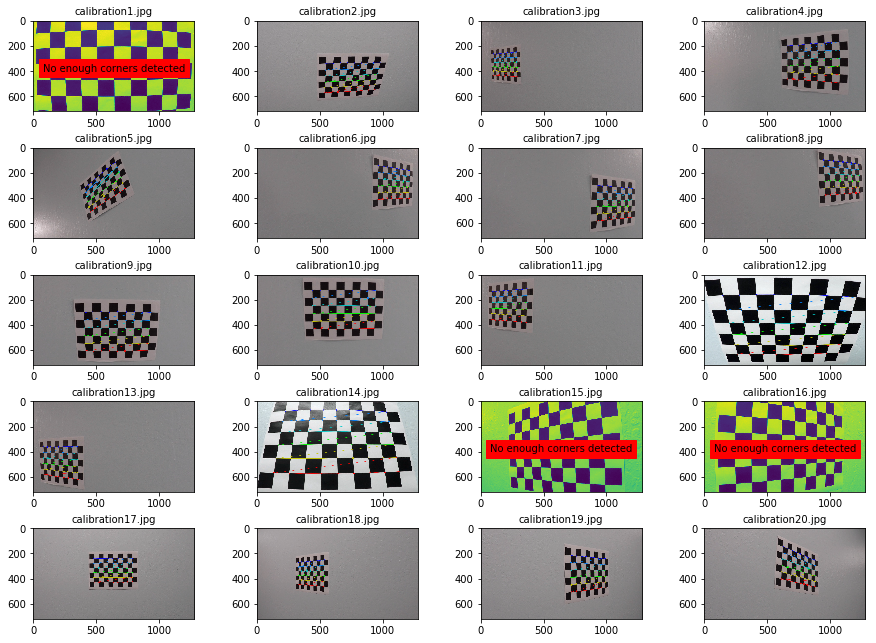

In [63]:
"""
Cell for calibrating camera
"""
import glob

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11), squeeze=False)
fig.subplots_adjust(hspace = 0.4, wspace= 0.01)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].imshow(img)
    else:
        axs[i].imshow(gray)
        axs[i].text(x = 75, y = 400, s = "No enough corners detected", fontsize=10, backgroundcolor='red')
        print(fname,"doesnt have enough corners detected.")
    axs[i].set_title('calibration%d.jpg' %(i+1), fontsize=10)
fig.savefig('output_images/calibration.png', bbox_inches = 'tight')

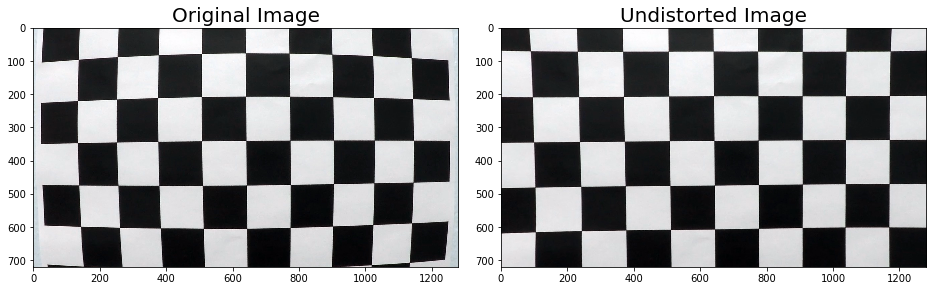

In [57]:
"""
Cell for undistorting images based on objpoints and imgpoints gained above
"""

def undistortImage(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

original_image = cv2.imread('camera_cal/calibration1.jpg')
undistorted_image = undistortImage(original_image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,11))
f.subplots_adjust(hspace = 0.2, wspace = 0.1)
ax1.imshow(original_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=20)
f.savefig('output_images/undistorted_image.png', bbox_inches = 'tight')